In [1]:
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
INPUT_DATA_PATH = "/kaggle/input/ashrae-energy-prediction"

MIN_TRAIN_TIMESTAMP = pd.Timestamp("2016-01-01 00:00:00")
MAX_TRAIN_TIMESTAMP = pd.Timestamp("2016-12-31 23:00:00")
TRAIN_DATA_RESOLUTION = "1h"

In [6]:
# Load meter readings
readings_df = pd.read_csv(
    f"{INPUT_DATA_PATH}/train.csv",
    header=0,
    names=["building_id", "meter_id", "timestamp", "meter_reading"],
)
readings_df["timestamp"] = pd.to_datetime(readings_df["timestamp"])
readings_df["ln_meter_reading"] = np.log1p(readings_df["meter_reading"])

In [251]:
def find_constant_streaks(
    df: pd.DataFrame,
    streak_length: int = 10,
    target_column: str = "ln_meter_reading"
):
    # Compute diffs on target col
    df = df.copy()
    df = df.sort_values("timestamp")
    df["target_col_diff"] = df[target_column].diff()
    df["zero_diff"] = (df["target_col_diff"] == 0)
    
    # First find any periods of constant meter readings
    streaks = []
    current_streak_start = None
    for idx, row in df.iterrows():
        if not row["zero_diff"]:
            # Streak finished
            # Save if there is currently a running streak
            if current_streak_start is not None:
                streaks.append((current_streak_start, idx - 1))
    
            # Reset
            current_streak_start = None
            
        else:
            # Start a new streak if not already a running streak
            current_streak_start = current_streak_start or idx - 1

    # Only keep streaks with length >= streak_length
    filtered_streaks = []
    for start, end in streaks:
        streak_df = df.loc[start: end]
        assert (streak_df["target_col_diff"] == 0).all()
        if len(streak_df) >= streak_length:
            start_t = streak_df["timestamp"].min()
            end_t = streak_df["timestamp"].max()
            filtered_streaks.append((start_t, end_t))
    
    return filtered_streaks

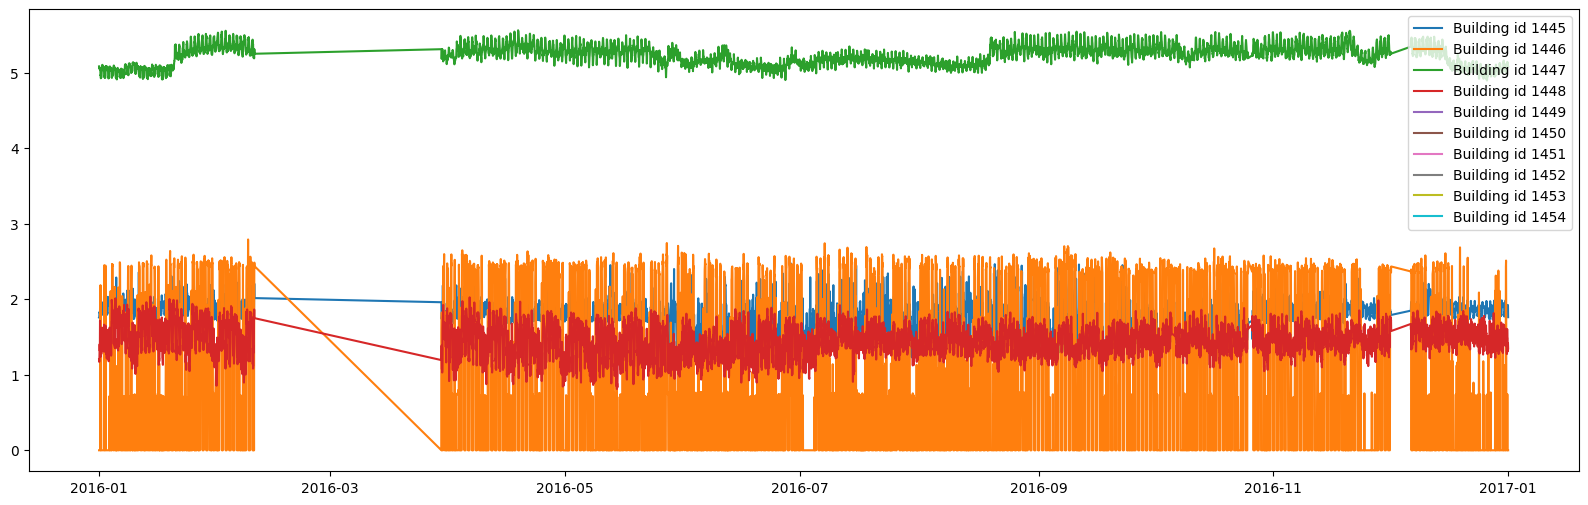

In [457]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 0
start_id = 1445
building_ids = range(start_id, start_id + 10)

df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = df[df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()
# ax.set(xlim=(datetime(2016, 5, 1), datetime(2016, 6, 1)))
# ax.axvline(datetime(2016, 7, 1))

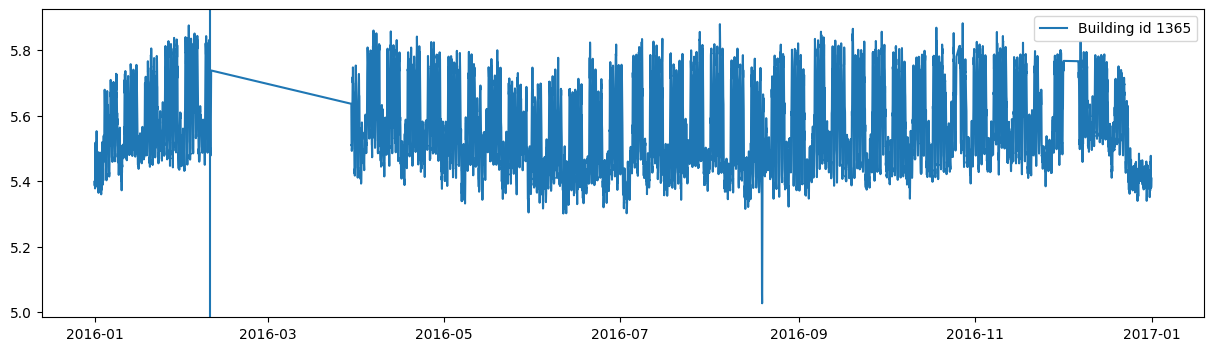

In [447]:
# Find timestamps of constant meter readings

meter_id = 0
building_id = 1365

bm_df = readings_df[(readings_df["building_id"] == building_id) & (readings_df["meter_id"] == meter_id)].copy()
constant_streaks = find_constant_streaks(bm_df, 25)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(
    bm_df["timestamp"].values,
    bm_df["ln_meter_reading"].values,
    label=f"Building id {building_id}"
)

ax.legend()

for start, end in constant_streaks:
    print(start.to_pydatetime(), end.to_pydatetime())
    ax.axvline(x=start, label=start, color="black", lw=2)
    ax.axvline(x=end, label=end, color="black", lw=2)
ax.axvline(datetime(2016, 2, 10))

In [4]:
# Meter_id = 0
# Below is all data to keep to by building id
# If a building id is missing -> keep all data
to_keep = {
    0: >= datetime(2016, 5, 21),
    2: >= datetime(2016, 5, 21),
    3: >= datetime(2016, 5, 21),
    4: >= datetime(2016, 5, 21),
    # same for up to ... 28
    29: >= datetime(2016, 8, 21),
    30: >= datetime(2016, 5, 21),
    # ... same up to ... 44
    45: >= datetime(2016, 7, 1),
    46: (<= datetime(2016, 3, 1), >= datetime(2016, 5, 21)),
    47: >= datetime(2016, 7, 1),
    # ... same up to 52
    53: None  # remove completely?
    54: >= datetime(2016, 7, 1),
    # ... same up to 104
    376: (<= datetime(2016, 3, 25), >= datetime(2016, 5, 10)),
    468; (<= datetime(2016, 8, 4), >= datetime(2016, 9, 25)),
    545: (<= datetime(2016, 1, 17), >= datetime(2016, 2, 10)),
    740: None  # remove completely?,
    803: (<= datetime(2016-09-24)),
    857: (<= datetime(2016, 4, 13))
    1264: (<= datetime(2016, 8, 22))
    1345: (<= datetime(2016, 2, 10))
    
    
}

# The below need to be removed due to constant streaks
# Apply constant filtering function with streak length = 25
to_remove = [
    105 -> 125,  # Might not find streaks in all of these
    136 -> 145,
    145 -> 155,
    177 -> 185,
    218,
    245 -> 254,
    269,
    278,
    537,
    577,
    604,
    681,
    693,
    723,
    733,
    738,
    799,
    802,
    874,
    875 -> 884,
    886,
    897,
    # Possibly not for 900 -> 996 ?
    905 -> 945,
    954 -> 996,
    1066,
    1079,
    1096,
    1098,
    1113,
    1128,
    1153,
    1154,
    1157,
    1160,
    1169,
    1177,
    1185,
    1202,
    1221,
    1225 -> 1324, # careful of 1227, 1281, 1314
    1359,
    
    
]

,building_id,meter_id,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0
